In [61]:
import pandas as pd
import pandas_profiling as pp
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

import json

%matplotlib inline

In [41]:
full_data = pd.read_csv("../data/test2.csv")
pp.ProfileReport(full_data).to_file(outputfile="./profile-test-full.html")

In [71]:
feature_cols = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_REDACAO"]
data = pd.read_csv("../data/test2.csv",
                         usecols=["NU_INSCRICAO"]+feature_cols)
#pp.ProfileReport(data).to_file(outputfile="./profile-test.html")
target_col = ["NU_NOTA_MT"]
usecols = feature_cols + target_col
data_train = pd.read_csv("../data/train.csv", usecols=usecols).dropna()
#pp.ProfileReport(data_train).to_file(outputfile="./profile-train.html")

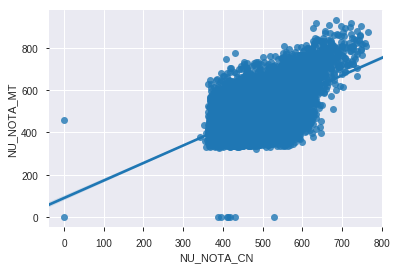

In [72]:
sns.regplot(x="NU_NOTA_CN", y="NU_NOTA_MT", data=data_train)
#sns.pairplot(data_train)

In [78]:
x_train, x_test, y_train, y_test = train_test_split(
    data_train[feature_cols], data_train[target_col], test_size=0.3, random_state=0)

model = linear_model.LinearRegression(normalize=False)
model.fit (x_train, y_train)
y_pred = model.predict(x_test)
metrics.explained_variance_score(y_test, y_pred)

0.4122506886462908

In [79]:
result = (
    data
    .assign(NU_NOTA_MT=lambda df: model.predict(df[feature_cols]))
    [["NU_INSCRICAO", "NU_NOTA_MT"]]
)
answer = result.to_dict("records")
submission = {
    "token": "5cfb5e6838b5b71058949df3e8746d3ff1c31a73",
    "email": "igor.a.r.y@gmail.com",
    "answer": answer
}
with open("submission.json", "w") as fp:
    json.dump(submission, fp)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').